# Determining the age of buyers

The online supermarket is implementing a computer vision system to process customers' photos. Capturing photos at the checkout area will help determine the age of customers in order to:

- Analyze purchases and recommend products that may interest customers in that age group.
- Monitor cashiers' compliance when selling alcohol.

Build a model that can approximate a person's age based on a photograph. You have a dataset of people's photos with their corresponding ages.

## Research data analysis

In [2]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

First, let's look at a set of images

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(
                    rescale=1./255,
                    horizontal_flip=True,
                    rotation_range=6,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    )
photo_set = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.



In the end, we have 7591 photos. Considering that the age ranges from 1 to 100 and there are two genders, we have approximately 38 photos per age group of peers. Additionally, we need to account for at least 3 races, which means we only have around 10 photos for each age-gender-race cohort. However, it's important to note that people's appearances can vary significantly (thin, overweight, bald, hairy, etc.). Thus, such a small sample size is insufficient for training a high quality model considering the multitude of important features.

There are also differences in the positioning of the images, but we can address this through shifts and rotations, as described further.

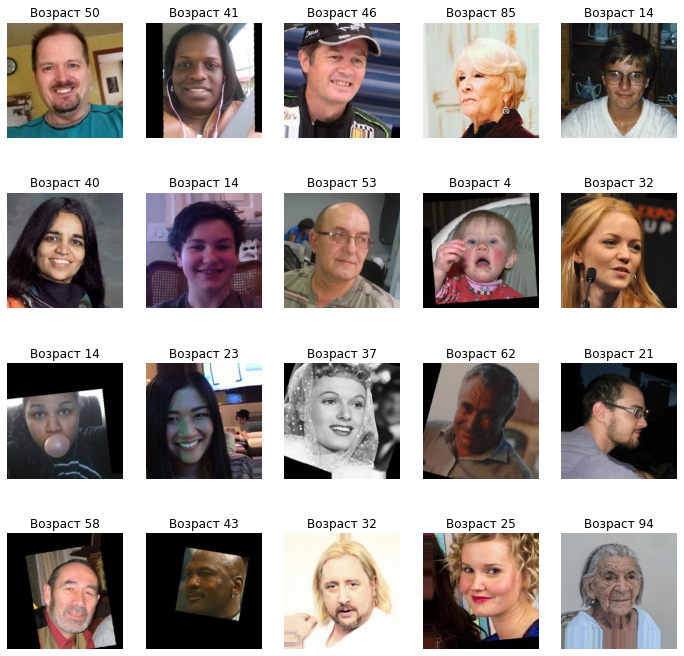

In [5]:
x, y = next(photo_set)
fig = plt.figure(figsize=(12,12))
for i in range(20):
    fig.add_subplot(4, 5, i+1)
    plt.imshow(x[i])
    plt.axis('off')
    plt.title(f'Возраст {y[i]}')

From the obtained images, the main problem with the dataset becomes apparent. Some of the photos have dimensions smaller than the standard 224x224, resulting in a significant portion of the background having zero signal, which negatively affects the training quality. Additionally, not all images show only the face; some capture the entire person in different poses, while others include multiple individuals in the frame, and so on. Therefore, a more meticulous approach is necessary to filter the dataset.

To begin with, it would be advisable to exclude images where the empty background constitutes more than, let's say, 50% of the image. As a first step, we can focus on detecting and extracting the faces, and then train the model specifically on those face images.

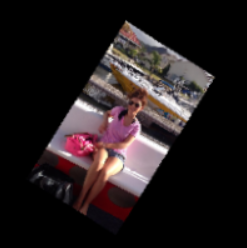

The second problem is the presence of black and white images, they should distort depending on the color, skin pigmentation, etc.

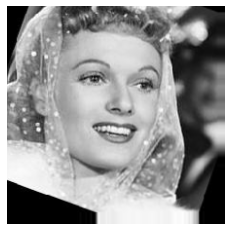

In [7]:
plt.imshow(x[12])
plt.axis('off')
plt.show()

Consider the distribution of age. It can be seen from the histogram that there is a data gap in the region of 10 years. The age varies from 1 to 100. The average age is 31 years, the median value is 29 years.

In [8]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

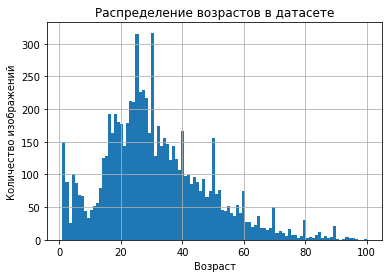

In [12]:
labels['real_age'].hist(bins=100)
plt.title('Распределение возрастов в датасете')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.show()

The histogram shows another important problem. Since the number of photos is unevenly distributed, for some ages the number of photos is only a couple of pieces, which makes learning impossible.

**Conclusions: During the analysis of the dataset, the following key shortcomings were identified:**

- The number of images in the dataset is insufficient for a complex task like age regression.
- The chosen images are unsuitable for this task: low image quality, some images in black and white, presence of other people, full-body photographs instead of focusing on the face, and other issues.
- The small number of images

To address some of these issues, it is necessary to filter the data. Additionally, a solution could involve using a network specifically designed to detect and extract faces from the images, thus adjusting the dataset to the desired format.

## Model training

The code was run in the cloud, here is the result of the calculation

```python
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

def load_train(path):
    """Загружаем тренировочную выборку"""
    
    train_datagen = ImageDataGenerator(
                    validation_split=0.25,
                    rescale=1./255,
                    horizontal_flip=True,
                    rotation_range=6,
                    width_shift_range=0.15,
                    height_shift_range=0.15
                    )

    directory = path +'/final_files'
    labels = pd.read_csv('/datasets/faces/labels.csv')
    
    train_generator=train_datagen.flow_from_dataframe(
                dataframe=labels,
                directory=directory,
                x_col="file_name",
                y_col="real_age",
                subset="training",
                batch_size=16,
                seed=123,
                shuffle=True,
                class_mode="raw",
                target_size=(224,224))
    
    return train_generator

def load_test(path):
    """Загружаем тестовую выборку"""
    
    train_datagen = ImageDataGenerator(
                rescale=1./255,validation_split=0.25)

    directory = path +'/final_files'
    labels = pd.read_csv('/datasets/faces/labels.csv')
    
    train_generator=train_datagen.flow_from_dataframe(
                dataframe=labels,
                directory=directory,
                x_col="file_name",
                y_col="real_age",
                subset="validation",
                batch_size=16,
                seed=123,
                shuffle=True,
                class_mode="raw",
                target_size=(224,224))

    return train_generator

def create_model(input_shape):
    """Создаем модель на основе ResNet50"""
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False) 

    model = Sequential()
    model.add(backbone)
    model.add(Dropout(0.5,seed=123))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    optimizer = Adam(lr=0.00002)
    model.compile(optimizer = optimizer,
	          loss='mean_squared_error',
		  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=8,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

```
Train for 178 steps, validate for 60 steps
Epoch 1/8
178/178 - 96s - loss: 841.2297 - mae: 24.3788 - val_loss: 1137.5017 - val_mae: 29.0754
Epoch 2/8
178/178 - 89s - loss: 234.8314 - mae: 11.8743 - val_loss: 1128.4215 - val_mae: 28.9162
Epoch 3/8
178/178 - 91s - loss: 122.5525 - mae: 8.3124 - val_loss: 1030.7397 - val_mae: 27.3598
Epoch 4/8
178/178 - 92s - loss: 91.7445 - mae: 7.2229 - val_loss: 232.5992 - val_mae: 11.1825
Epoch 5/8
178/178 - 105s - loss: 73.6216 - mae: 6.4951 - val_loss: 103.9506 - val_mae: 7.6369
Epoch 6/8
178/178 - 106s - loss: 66.7747 - mae: 6.2527 - val_loss: 86.0434 - val_mae: 6.8564
Epoch 7/8
178/178 - 103s - loss: 56.3522 - mae: 5.7693 - val_loss: 84.1840 - val_mae: 6.8364
Epoch 8/8
178/178 - 95s - loss: 52.2556 - mae: 5.5684 - val_loss: 86.3256 - val_mae: 6.7756
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 86.3256 - mae: 6.7756
Test MAE: 6.7756
```

```
356/356 - 97s - loss: 43.2071 - mae: 5.1001 - val_loss: 78.0547 - val_mae: 6.6924
Epoch 8/12
356/356 - 101s - loss: 37.7871 - mae: 4.7696 - val_loss: 95.1488 - val_mae: 7.5061
Epoch 9/12
356/356 - 108s - loss: 36.0231 - mae: 4.6442 - val_loss: 72.8436 - val_mae: 6.1544
Epoch 10/12
356/356 - 99s - loss: 29.8870 - mae: 4.2478 - val_loss: 71.0060 - val_mae: 6.1856
Epoch 11/12
356/356 - 104s - loss: 27.3520 - mae: 4.0483 - val_loss: 73.7412 - val_mae: 6.2804
Epoch 12/12
356/356 - 107s - loss: 24.9327 - mae: 3.8504 - val_loss: 76.5006 - val_mae: 6.4037
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 76.5006 - mae: 6.4037
Test MAE: 6.4037
```

## Analysis of the trained model

The model achieved satisfactory results; however, such a level of accuracy cannot replace a cashier. During the experimentation, the parameters of the ImageDataGenerator were varied, with the most important ones being mirror reflection, image rotation, and horizontal and vertical shifts. It was observed that when the rotation angle exceeded 10-15 degrees, the model's performance did not improve, and for angles over 15 degrees, the accuracy started to decline. Similarly, shifts greater than 0.2 resulted in faces extending beyond the frame.

Most of the models showed that the best results were obtained around the 4th epoch, with a learning rate (lr) ranging from 0.0001 to 0.00001. Adding a fully connected layer after the ResNet architecture accelerated the training process, but the accuracy did not drop below 7.2. The inclusion of dropout did not have a significant impact on training.
